In [1]:
%reload_ext autoreload
%autoreload 2

In [ ]:
!pip install openpyxl
!pip install tenacity
!pip install loguru
!pip install git+ssh://git@github.com/NASA-IMPACT/evalem.git@develop
!pip install rake-nltk

In [2]:
import json
from typing import List

In [3]:
from pprint import pprint
from IPython.display import display, HTML

In [4]:
from loguru import logger
import glob
import random
import re

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Load Validation Data

In [6]:
FILE_PATH = "data/OSDR_LLM_QA_correctFormat.xlsx"

In [7]:
def load_data(path) -> pd.DataFrame:
    data = pd.read_excel(path)
    data = data.rename(columns={data.columns[0]: 'context'})
    return data

In [8]:
def simplify_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    transformed_data = []
    for index, row in df.iterrows():
        context = row['context']
        url = row['URL']
        for i in range(1, 6): # Assuming there are 5 question-answer pairs
            question = row[f'Question {i}']
            answer = row[f'Question {i} Answer']
            if question and answer:
                transformed_data.append(dict(
                    context=context,
                    context_hash=abs(hash(context)) % (10 ** 8),
                    url=url,
                    question=question,
                    answer=answer,
                ))
    df =  pd.DataFrame(transformed_data)
    return df.dropna(subset=['question', 'answer'], how='all')

In [9]:
data = load_data(FILE_PATH)
data.head()

,context,URL,Question 1,Question 1 Answer,Question 2,Question 2 Answer,Question 3,Question 3 Answer,Question 4,Question 4 Answer,Question 5,Question 5 Answer
0,Genome-wide transcriptional profiling showed t...,https://sciencediscoveryengine.nasa.gov#/previ...,Where were the gene expression alterations in ...,reducing gravity levels in the International S...,What kind of experiments showed differential r...,simulation experiments on ground testing space...,What is overrepresented in the different exper...,the same GO groups including a large multigene...,what analytical methodology provided integrati...,Self-organizing maps of the Gene Expression Dy...,What are the implications of the findings in t...,The findings indicate that the finely adjusted...
1,The objective of the Rodent Research-5 (RR-5) ...,https://sciencediscoveryengine.nasa.gov#/previ...,What was the main goal of the Rodent Research-...,to evaluate bone loss in mice during spaceflig...,What type of mice and how old were they when f...,a cohort of forty 30-weeks-old female BALB/cAn...,How many days after launch were the mice treat...,Six days after launch,How was the Earth recovery period for the subj...,"Following their return to Earth, the experimen...",What specific type of samples and from which c...,GeneLab received RNA later preserved dorsal sk...
2,The radiation bystander response is an importa...,https://sciencediscoveryengine.nasa.gov#/previ...,What is a key component of the overall respons...,The radiation bystander response,Which methods were used to measure the bystand...,using chromosomal aberration and micronucleus ...,What was shown to increase chromosomal structu...,depletion or mutation of RAD9,what cellular pathways were altered as a resul...,The depletion of RAD9 caused changes in numero...,How were differences in the activation of tran...,The use of network analysis allowed the discov...
3,Martian regolith (unconsolidated surface mater...,https://sciencediscoveryengine.nasa.gov#/previ...,What is considered a potential medium for plan...,Martian regolith (unconsolidated surface mater...,What is the level of hydrated magnesium sulfat...,hydrated magnesium sulfate mineral levels in t...,What was characterized in the study to identif...,The early Arabidopsis root transcriptome respo...,how was the genetic comparison approached to d...,A comparative analysis was conducted between t...,What distinctive characteristic does the cax1-...,The cax1-1 mutant line demonstrated relative t...
4,The objective of the Rodent Research-23 missio...,https://sciencediscoveryengine.nasa.gov#/previ...,What was the objective of the Rodent Research-...,to better understand the effects of spacefligh...,How many mice and of what type were involved i...,"twenty male, C57BL/6J, 16-17 weeks-old mice",How long were the mice in the RR-23 study main...,maintained in microgravity for 38 days,What was the procedure followed for the mice f...,"The mice, after landing in the Atlantic, were ...",How was RNA extraction and analysis managed fo...,Adrenal glands of the mice were preserved by i...


## Data Peek

Here we pick a sample row to inspect the nature of data.
- What each column looks like

In [13]:
def peek_data(data: pd.DataFrame, row_index: int = 0):
    print(f"Row = {row_index}")
    row = data.iloc[row_index]
    for col, value in zip(data.columns, row):
        display(HTML(f"<h4>{col}</h4>"))
        print(value)
        display(HTML("<hr/>"))

In [14]:
data.shape

(60, 12)

In [15]:
# index = random.randint(0, len(data))
peek_data(data, row_index=0)

Row = 0


Genome-wide transcriptional profiling showed that reducing gravity levels in the International Space Station (ISS) causes important alterations in Drosophila gene expression intimately linked to imposed spaceflight-related environmental constrains during Drosophila metamorphosis. However, simulation experiments on ground testing space-related environmental constraints, show differential responses. Curiously, although particular genes are not common in the different experiments, the same GO groups including a large multigene family related with behavior, stress response and organogenesis are over represented in them. A global and integrative analysis using the gene expression dynamics inspector (GEDI) self-organizing maps, reveals different degrees in the responses of the transcriptome when using different environmental conditions or microgravity/hypergravity simulation devices. These results suggest that the transcriptome is finely tuned to normal gravity. In regular environmental cond

https://sciencediscoveryengine.nasa.gov#/preview?id=%2FSDE%2Fgenelab_lsda%2F%7Chttps:%2F%2Fosdr.nasa.gov%2Fbio%2Frepo%2Fdata%2Fstudies%2FOSD-70%2F&query=%7B%22name%22:%22query-smd-primary%22,%22scope%22:%22All%22,%22text%22:%22osd-70%22%7D


Where were the gene expression alterations in Drosophila observed during their metamorphosis?


reducing gravity levels in the International Space Station (ISS)


What kind of experiments showed differential responses in gene expression?


simulation experiments on ground testing space-related environmental constraints


What is overrepresented in the different experiments despite particular genes not being common?


the same GO groups including a large multigene family related with behavior, stress response and organogenesis


what analytical methodology provided integrative insights on transcriptome variations?


Self-organizing maps of the Gene Expression Dynamics Inspector (GEDI) were utilized to reveal transcriptome variations under various environmental conditions or microgravity/hypergravity simulation devices.


What are the implications of the findings in terms of the tuning of the transcriptome to Earth's gravity and its variations in extreme environmental conditions?


The findings indicate that the finely adjusted transcriptome is tuned to normal Earth gravity, showing a more marked and coherent genetic response when environmental conditions significantly deviate from optimal.


## Simplify Data

Here we separate out individual question/answer pair into separate row for each context.
This is used for simplifying the validation process so that each row would have consistent view of data.

In [16]:
data = simplify_columns(data)
data.head(10)

,context,context_hash,url,question,answer
0,Genome-wide transcriptional profiling showed t...,24878159,https://sciencediscoveryengine.nasa.gov#/previ...,Where were the gene expression alterations in ...,reducing gravity levels in the International S...
1,Genome-wide transcriptional profiling showed t...,24878159,https://sciencediscoveryengine.nasa.gov#/previ...,What kind of experiments showed differential r...,simulation experiments on ground testing space...
2,Genome-wide transcriptional profiling showed t...,24878159,https://sciencediscoveryengine.nasa.gov#/previ...,What is overrepresented in the different exper...,the same GO groups including a large multigene...
3,Genome-wide transcriptional profiling showed t...,24878159,https://sciencediscoveryengine.nasa.gov#/previ...,what analytical methodology provided integrati...,Self-organizing maps of the Gene Expression Dy...
4,Genome-wide transcriptional profiling showed t...,24878159,https://sciencediscoveryengine.nasa.gov#/previ...,What are the implications of the findings in t...,The findings indicate that the finely adjusted...
5,The objective of the Rodent Research-5 (RR-5) ...,41570944,https://sciencediscoveryengine.nasa.gov#/previ...,What was the main goal of the Rodent Research-...,to evaluate bone loss in mice during spaceflig...
6,The objective of the Rodent Research-5 (RR-5) ...,41570944,https://sciencediscoveryengine.nasa.gov#/previ...,What type of mice and how old were they when f...,a cohort of forty 30-weeks-old female BALB/cAn...
7,The objective of the Rodent Research-5 (RR-5) ...,41570944,https://sciencediscoveryengine.nasa.gov#/previ...,How many days after launch were the mice treat...,Six days after launch
8,The objective of the Rodent Research-5 (RR-5) ...,41570944,https://sciencediscoveryengine.nasa.gov#/previ...,How was the Earth recovery period for the subj...,"Following their return to Earth, the experimen..."
9,The objective of the Rodent Research-5 (RR-5) ...,41570944,https://sciencediscoveryengine.nasa.gov#/previ...,What specific type of samples and from which c...,GeneLab received RNA later preserved dorsal sk...


In [17]:
data.shape

(295, 5)

In [18]:
peek_data(data, row_index=0)

Row = 0


Genome-wide transcriptional profiling showed that reducing gravity levels in the International Space Station (ISS) causes important alterations in Drosophila gene expression intimately linked to imposed spaceflight-related environmental constrains during Drosophila metamorphosis. However, simulation experiments on ground testing space-related environmental constraints, show differential responses. Curiously, although particular genes are not common in the different experiments, the same GO groups including a large multigene family related with behavior, stress response and organogenesis are over represented in them. A global and integrative analysis using the gene expression dynamics inspector (GEDI) self-organizing maps, reveals different degrees in the responses of the transcriptome when using different environmental conditions or microgravity/hypergravity simulation devices. These results suggest that the transcriptome is finely tuned to normal gravity. In regular environmental cond

24878159


https://sciencediscoveryengine.nasa.gov#/preview?id=%2FSDE%2Fgenelab_lsda%2F%7Chttps:%2F%2Fosdr.nasa.gov%2Fbio%2Frepo%2Fdata%2Fstudies%2FOSD-70%2F&query=%7B%22name%22:%22query-smd-primary%22,%22scope%22:%22All%22,%22text%22:%22osd-70%22%7D


Where were the gene expression alterations in Drosophila observed during their metamorphosis?


reducing gravity levels in the International Space Station (ISS)


In [19]:
peek_data(data, row_index=1)

Row = 1


Genome-wide transcriptional profiling showed that reducing gravity levels in the International Space Station (ISS) causes important alterations in Drosophila gene expression intimately linked to imposed spaceflight-related environmental constrains during Drosophila metamorphosis. However, simulation experiments on ground testing space-related environmental constraints, show differential responses. Curiously, although particular genes are not common in the different experiments, the same GO groups including a large multigene family related with behavior, stress response and organogenesis are over represented in them. A global and integrative analysis using the gene expression dynamics inspector (GEDI) self-organizing maps, reveals different degrees in the responses of the transcriptome when using different environmental conditions or microgravity/hypergravity simulation devices. These results suggest that the transcriptome is finely tuned to normal gravity. In regular environmental cond

24878159


https://sciencediscoveryengine.nasa.gov#/preview?id=%2FSDE%2Fgenelab_lsda%2F%7Chttps:%2F%2Fosdr.nasa.gov%2Fbio%2Frepo%2Fdata%2Fstudies%2FOSD-70%2F&query=%7B%22name%22:%22query-smd-primary%22,%22scope%22:%22All%22,%22text%22:%22osd-70%22%7D


What kind of experiments showed differential responses in gene expression?


simulation experiments on ground testing space-related environmental constraints


# promptlab 


**promptlab** provides a programmatic approach to interact with the bot via its REST API.
Specificially, the `/process/` endpoint can process any query and generate the respond accordingly.
https://api.promptlab.nasa-impact.net/api/v1/process/

We can send a request to the API with the query/question and get the response.

Here, the `FlowRunner` class abstracts everything. Its `.run(...)` method processes the query which:
- Takes in a query string
- Returns a result json/dictionary

The result from the API tentatively gives us following information:

- *question* : input question fed into the bot
- *answer* : generated answer based on retrieved contexts
- *retrieved contexts* : List of **top-k** contexts retrieved by the RAG system

## setup flow processors

In [20]:
import requests
from typing import Optional, Union
import urllib.parse

In [21]:
from loguru import logger

In [22]:
from tenacity import retry, retry_if_result, stop_after_attempt, wait_fixed, retry_if_exception, retry_if_exception_type

In [23]:
# Setup the base URL to point to the production
BASE_API_URL = "https://api.promptlab.nasa-impact.net/api/v1/process/"

# Setup api key to authenticate
PROMPTLAB_API_KEY =  "sk-e0bvhSxSSk5Vw16d-8s1cVGjUcr9d7nam49-6K28FZQ"

In [24]:
# tweaks for the OSDR bot flow
TWEAKS = {
  "ConversationalRetrievalChain-83vns": {},
  "ChatOpenAI-gsfUD": {"model": "gpt-3.5-turbo"},
  "ConversationBufferMemory-z2ZqE": {},
  "Sinequa-Z8S73": {}
}

# flow id of the OSDR bot in promptlab that is used for QA programmatically
FLOW_ID = "1edbe0f9-d7ff-4c2a-a371-5f6312964f05"

In [25]:
class FlowRunner:
    def __init__(self, base_url: str, api_key: str, debug:bool = False) -> None:
        self.base_url = base_url
        self.api_key = api_key
        self.debug=bool(debug)

    def run_flow(
        self,
        inputs: dict,
        flow_id: str,
        tweaks: Optional[dict] = None,
    ) -> dict:
        """
        Run a flow with a given message and optional tweaks.
    
        :param message: The message to send to the flow
        :param flow_id: The ID of the flow to run
        :param tweaks: Optional tweaks to customize the flow
        :return: The JSON response from the flow
        """
        api_url = urllib.parse.urljoin(self.base_url, flow_id)
        if self.debug:
            logger.debug(f"URL = {api_url}")

        api_key = self.api_key
        payload = {"inputs": inputs}
        headers = None
        if tweaks:
            payload["tweaks"] = tweaks
        if api_key:
            headers = {"x-api-key": api_key}
        response = requests.post(api_url, json=payload, headers=headers)
        if self.debug:
            logger.debug(f"response = {response}")
            logger.debug(f"status code = {response.status_code}")
        if response.status_code != 200:
            raise requests.exceptions.HTTPError(f"Error: {response.status_code}")
        return response.json()

    @staticmethod
    def if_not_valid_result(result: dict) -> bool:
        return not (isinstance(result, dict) and "result" in result and "answer" in result.get("result", {}))
    
    @retry(
        retry=(retry_if_exception_type(requests.exceptions.RequestException) | retry_if_result(if_not_valid_result)),
        stop=stop_after_attempt(3),
        wait=wait_fixed(2)
    )
    def run(
        self,
        input: Union[dict, str],
        flow_id: str,
        tweaks: Optional[dict] = None,
    ) -> dict:
        if isinstance(input, str):
            input = dict(question=input)
        result = self.run_flow(
            inputs=input,
            flow_id=flow_id,
            tweaks=tweaks,
        )
        result["question"] = input["question"] if isinstance(input, dict) else input

        if "result" in result:
            source_documents = result.get("result", {}).get("source_documents", "[]")
            if isinstance(source_documents, str):
                result["result"]["source_documents"] = json.loads(source_documents)
        return result

    @staticmethod
    def display_result(result: dict, question: Optional[str]=None):
        header_tag = "h4"
        question = result.get("question", question)
        if question:
            display(HTML(f"<{header_tag}>question</{header_tag}>"))
            print(question)
            display(HTML("<hr/>"))

        if "result" in result:
            result = result["result"]
        display(HTML(f"<{header_tag}>answer</{header_tag}>"))
        print(result["answer"])
        display(HTML("<hr/>"))
        
        # display(HTML(f"<{header_tag}>Retrieved Contexts</{header_tag}>"))
        for idx, doc in enumerate(result["source_documents"], start=1):
            display(HTML(f"<{header_tag}>Retrieved Context #{idx}</{header_tag}>"))
            print(doc["page_content"])
            print(doc["metadata"]["source"])
            display(HTML("<hr/>"))

## Test Run

Now, let's check what a sample test run looks like when we call the API for QA.

In [26]:
flow_runner = FlowRunner(
    base_url=BASE_API_URL,
    api_key=PROMPTLAB_API_KEY
)

In [27]:
query = "What parasites were sent to ISS to study host immunity?"

In [28]:
result = flow_runner.run(
    input=query,
    flow_id=FLOW_ID,
    tweaks=TWEAKS,
)

In [29]:
result["question"]

'What parasites were sent to ISS to study host immunity?'

In [30]:
flow_runner.display_result(result)

What parasites were sent to ISS to study host immunity?


In the studies mentioned, parasitic wasps Leptopilina boulardi 17 and Leptopilina heterotoma 14 were sent to the ISS to study host immunity.


In this <b>study</b>, fruit flies and their parasitic wasps were <b>sent</b> to the <b>ISS</b> to examine changes in <b>host</b> <b>immunity</b> and <b>parasite</b> virulence. Key findings from this work are as follows: (a) Spaceflight spiked the expression of inflammation genes in fruit flies; (b) Spaceflight enhanced tumor growth in flies already suffering from chronic inflammation; (c) Spaceflight did not significantly affect parasitic wasp development, emergence, or the expression of virulence genes; (d) <b>Parasite</b> mutants with visible wing color and shape alterations were obtained. This <b>study</b> contains Drosophila melanogaster data.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-588/


In this <b>study</b>, fruit flies and their parasitic wasps were <b>sent</b> to the <b>ISS</b> to examine changes in <b>host</b> <b>immunity</b> and <b>parasite</b> virulence. Key findings from this work are as follows: (a) Spaceflight spiked the expression of inflammation genes in fruit flies; (b) Spaceflight enhanced tumor growth in flies already suffering from chronic inflammation; (c) Spaceflight did not significantly affect parasitic wasp development, emergence, or the expression of virulence genes; (d) <b>Parasite</b> mutants with visible wing color and shape alterations were obtained. This <b>study</b> contains Leptopilina boulardi 17 data.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-610/


In this <b>study</b>, fruit flies and their parasitic wasps were <b>sent</b> to the <b>ISS</b> to examine changes in <b>host</b> <b>immunity</b> and <b>parasite</b> virulence. Key findings from this work are as follows: (a) Spaceflight spiked the expression of inflammation genes in fruit flies; (b) Spaceflight enhanced tumor growth in flies already suffering from chronic inflammation; (c) Spaceflight did not significantly affect parasitic wasp development, emergence, or the expression of virulence genes; (d) <b>Parasite</b> mutants with visible wing color and shape alterations were obtained. This <b>study</b> contains Leptopilina heterotoma14 data.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-609/


About  Charter  How to Join  Current AWG Members  Citizen Science  SOLSTICE  SOLSTICE Members  FAQ  Terms & Conditions  Genelab Tutorials  Contact Us  account_circle expand_more  1.26 TB  OSD-588 Version 1  Drosophila parasitoids go to space: Unexpected effects of spaceflight on <b>hosts</b> and their parasitoids - Drosophila data <b>Study</b>  Submitted Date: 02-Feb-2023  Initial Release Date: 02-Jan-2024  notifications share  GeneLab ID : GLDS-583 DOI : 10.26030/v9rh-5a70  Cite this <b>Study</b>  info Description  Description  In this <b>study</b>, fruit flies and their parasitic wasps were <b>sent</b> to the <b>ISS</b> to examine changes in <b>host</b> <b>immunity</b> and <b>parasite</b> virulence.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-588/


About  Charter  How to Join  Current AWG Members  Citizen Science  SOLSTICE  SOLSTICE Members  FAQ  Terms & Conditions  Genelab Tutorials  Contact Us  account_circle expand_more  148.92 GB  OSD-610 Version 1  Drosophila parasitoids go to space: Unexpected and differential effects of spaceflight on <b>hosts</b> and their parasitoids - Wasp Leptopilina boulardi 17 data <b>Study</b>  Submitted Date: 28-Apr-2023  Initial Release Date: 02-Jan-2024  notifications share  GeneLab ID : GLDS-587 DOI : 10.26030/9ee4-6s36  Cite this <b>Study</b>  info Description  Description  In this <b>study</b>, fruit flies and their parasitic wasps were <b>sent</b> to the <b>ISS</b> to examine changes in <b>host</b> <b>immunity</b> and <b>parasite</b> virulence.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-610/


About  Charter  How to Join  Current AWG Members  Citizen Science  SOLSTICE  SOLSTICE Members  FAQ  Terms & Conditions  Genelab Tutorials  Contact Us  account_circle expand_more  176.26 GB  OSD-609 Version 1  Drosophila parasitoids go to space: Unexpected and differential effects of spaceflight on <b>hosts</b> and their parasitoids - Wasp Leptopilina heterotoma 14 data <b>Study</b>  Submitted Date: 28-Apr-2023  Initial Release Date: 02-Jan-2024  notifications share  GeneLab ID : GLDS-586 DOI : 10.26030/5rjq-a347  Cite this <b>Study</b>  info Description  Description  In this <b>study</b>, fruit flies and their parasitic wasps were <b>sent</b> to the <b>ISS</b> to examine changes in <b>host</b> <b>immunity</b> and <b>parasite</b> virulence.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-609/


The biology chosen for this experiment was Arabidopsis thaliana, ecotype Col-0, because of the plant's history of spaceflight experimentation within KFTs and wealth of comparative data from orbital experiments. KFTs were deployed as a wearable device, a leg pouch attached to the astronaut, which proved to be operationally effective during the course of the flight. Data from the inflight samples indicated that the microgravity period of the flight elicited the strongest transcriptomic responses as measured by the number of genes showing differential expression.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-624/


Fungal Pathogenesis , Tumorigenesis , and Effects of <b>Host</b> <b>Immunity</b> in Space  Project Type  Spaceflight <b>Study</b>  Flight Program  Space Transportation System (STS)  Experiment Platform  Shuttle Life Sciences Research (Middeck)  Sponsoring Agency  NASA  NASA Center  Ames Research Center (ARC)  Funding Source  This <b>study</b> work was supported by a NASA grant to SB for Fungal Pathogenesis, Tumorigenesis, and Effects of <b>Host</b> <b>Immunity</b> in the Space Environment (FSB-FIT-2005). The funder had a role in <b>study</b> design and in supporting data collection.  Acknowledgments  We thank David Schneider for helping us with the design of this experiment.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-3/


Spaceflight uniquely alters the physiology of both human cells and microbial pathogens, stimulating cellular and molecular changes directly relevant to infectious disease. However, the influence of this environment on host-pathogen interactions remains poorly understood. Here we report our results from the STL-IMMUNE study flown aboard Space Shuttle mission STS-131, which investigated multi-omic responses (transcriptomic, proteomic) of human intestinal epithelial cells to infection with Salmonella Typhimurium when both host and pathogen were simultaneously exposed to spaceflight. To our knowledge, this was the first in-flight infection and dual RNA-seq analysis using human cells.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-323/


Immune dysregulation is among the main adverse outcomes of spaceflight. Despite its crucial role in host protection, effects on the human antibody repertoire are unknown. Consequently, we examined the IgM repertoire of five cosmonauts 25 days before launch, after 64 and 129 days spent on the International Space Station (ISS), and after 1, 7 and 30 days of Earth reambulation using high-throughput sequencing. This is the first study of this kind.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-316/


# Run OSDR Validattion set

Instead of manually running each question through the bot to generate the answer, we run all the questions from the validation data in bulk.

We have some functions for housekeeping and the details for them are hidden away for brevity.

> Note: Since it takes some time to run through all the questions, we'll pre-load the responses from a csv.

In [31]:
from tqdm import tqdm
from joblib import Parallel, delayed
import ast

In [32]:
def process_row(row, flow_runner, flow_id, tweaks):
    try:
        result = flow_runner.run(input=row.question, flow_id=flow_id, tweaks=tweaks)
    except:
        logger.error(f"Error for question={row.question}. Skipping")
        result = {}
    print(result.keys())
    result["reference_context"] = row.context
    result["reference_answer"] = row.answer
    result["context_hash"] = row.context_hash
    return result

In [33]:
def get_osdr_responses(
    data: pd.DataFrame,
    flow_runner: FlowRunner,
    flow_id,
    tweaks
) -> pd.DataFrame:
    results = []
    for row in tqdm(data.itertuples()):
        result = process_row(row, flow_runner, flow_id, tweaks)
        results.append(result)
    return pd.DataFrame(results)

def get_osdr_responses_parallel(
    data: pd.DataFrame,
    flow_runner,
    flow_id, 
    tweaks
) -> pd.DataFrame:
    results = Parallel(n_jobs=-1, backend="threading")(
        delayed(process_row)\
        (row, flow_runner, flow_id, tweaks) for row in tqdm(data.itertuples(index=False))
    )
    results_df = pd.DataFrame(results)
    return results_df

In [34]:
def load_responses(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df["result"] = df["result"].apply(ast.literal_eval)
    return df

In [36]:
# # get all the responses
responses = get_osdr_responses_parallel(
    data=simplify_columns(load_data(FILE_PATH)).iloc[:],
    flow_runner=flow_runner,
    flow_id=FLOW_ID,
    tweaks=TWEAKS
)

In [37]:
# load already dumped responses
responses = load_responses("data/responses-gpt-3.5-turbo.csv")

In [38]:
responses.head(3)

,result,status,task,session_id,backend,question,reference_context,reference_answer,context_hash
0,{'answer': 'The gene expression alterations in...,NaN,"{'id': '139756224681744', 'href': 'api/v1/task...",RG8XKS:6b5b553ba5e766ccbc1429e4540911c1e7ac597...,anyio,Where were the gene expression alterations in ...,Genome-wide transcriptional profiling showed t...,reducing gravity levels in the International S...,30225908
1,{'answer': 'Experiments involving reducing gra...,NaN,"{'id': '139756227007232', 'href': 'api/v1/task...",JHTOXO:6b5b553ba5e766ccbc1429e4540911c1e7ac597...,anyio,What kind of experiments showed differential r...,Genome-wide transcriptional profiling showed t...,simulation experiments on ground testing space...,30225908
2,"{'answer': 'The same GO groups, including a la...",NaN,"{'id': '139756223614704', 'href': 'api/v1/task...",VWW7ZL:6b5b553ba5e766ccbc1429e4540911c1e7ac597...,anyio,What is overrepresented in the different exper...,Genome-wide transcriptional profiling showed t...,the same GO groups including a large multigene...,30225908


In [ ]:
responses.to_csv("data/responses-gpt-3.5-turbo.csv", index=False)

In [43]:
sample_row = responses.sample(1)
FlowRunner.display_result(sample_row.result.iloc[0], sample_row.question.iloc[0])

Which tools were used to assess percentage of rRNA?


The tools used to assess the percentage of rRNA in the provided context are Agilent 2100 Bioanalyzer and NanoDrop 2000 spectrophotometer.


to include conditions used for multiple RR missions and is designed to help determine factors which may confound data analysis. To determine whether these various factors affect changes in gene expression, this ground-based study generated gene expression profiles measured by RNAseq from the livers of 20-21 week-old female C57BL/6J mice. Multiple, interacting factors were investigated:
https://osdr.nasa.gov/bio/repo/data/studies/OSD-235/


1.45 percent  GLDS-120_rna_seq_Atha_Ws_root_FLT_Alight_Rep1_GSM2493780_Day13_R1_raw.fastq.gz , GLDS-120_rna_seq_Atha_Ws_root_FLT_Alight_Rep1_GSM2493780_Day13_R2_raw.fastq.gz  GLDS-120_rna_seq_raw_multiqc_report.zip  GeneLab RNAseq data processing protocol  GLDS-120_rna_seq_Atha_Ws_root_FLT_Alight_Rep1_GSM2493780_Day13_R1_trimmed.fastq.gz , GLDS-120_rna_seq_Atha_Ws_root_FLT_Alight_Rep1_GSM2493780_Day13_R2_trimmed.fastq.gz  GLDS-120_rna_seq_trimmed_multiqc_report.zip  GLDS-120_rna_seq_Atha_Ws_root_FLT_Alight_Rep1_GSM2493780_Day13_R1_raw.fastq.gz_trimming_report.txt , GLDS-120_rna_seq_Atha_Ws_root_FLT_Alight_Rep1_GSM2493780_Day13_R2_raw.fastq.gz_trimming_report.txt  GLDS-120_rna_seq_Atha_Ws_root_FLT_Alight_Rep1_GSM2493780_Day13_Aligned.sortedByCoord_sorted.out.bam , GLDS-120_rna_seq_Atha_Ws_root_FLT_Alight_Rep1_GSM2493780_Day13_Aligned.sortedByCoord_sorted.out.bam.bai , GLDS-120_rna_seq_Atha_Ws_root_FLT_Alight_Rep1_GSM2493780_Day13_Aligned.toTranscriptome.out.bam , GLDS-120_rna_seq_Atha_W

59.79 percent  GLDS-426_rna_seq_EU183_R1_raw.fastq.gz , GLDS-426_rna_seq_EU183_R2_raw.fastq.gz  GLDS-426_rna_seq_raw_multiqc_report.zip  GeneLab RNAseq data processing protocol  GLDS-426_rna_seq_EU183_R1_trimmed.fastq.gz , GLDS-426_rna_seq_EU183_R2_trimmed.fastq.gz  GLDS-426_rna_seq_trimmed_multiqc_report.zip  GLDS-426_rna_seq_EU183_R1_raw.fastq.gz_trimming_report.txt , GLDS-426_rna_seq_EU183_R2_raw.fastq.gz_trimming_report.txt  GLDS-426_rna_seq_EU183_Aligned.sortedByCoord_sorted.out.bam , GLDS-426_rna_seq_EU183_Aligned.sortedByCoord_sorted.out.bam.bai , GLDS-426_rna_seq_EU183_Aligned.toTranscriptome.out.bam , GLDS-426_rna_seq_EU183_SJ.out.tab  GLDS-426_rna_seq_EU183_Log.final.out  GLDS-426_rna_seq_align_multiqc_report.zip  GLDS-426_rna_seq_geneBody_cov_multiqc_report.zip , GLDS-426_rna_seq_infer_exp_multiqc_report.zip , GLDS-426_rna_seq_inner_dist_multiqc_report.zip , GLDS-426_rna_seq_read_dist_multiqc_report.zip  GLDS-426_rna_seq_EU183.genes.results , GLDS-426_rna_seq_EU183.isoforms.

1.17 percent  GLDS-295_rna_seq_raw_multiqc_report.zip  GeneLab RNAseq data processing protocol  GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLU_Rep1_trimmed.fastq.gz  GLDS-295_rna_seq_trimmed_multiqc_report.zip  GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLU_Rep1_raw.fastq.gz_trimming_report.txt  GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLU_Rep1_Aligned.sortedByCoord_sorted.out.bam , GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLU_Rep1_Aligned.sortedByCoord_sorted.out.bam.bai , GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLU_Rep1_Aligned.toTranscriptome.out.bam , GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLU_Rep1_SJ.out.tab  GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLU_Rep1_Log.final.out  GLDS-295_rna_seq_align_multiqc_report.zip  GLDS-295_rna_seq_geneBody_cov_multiqc_report.zip, GLDS-295_rna_seq_infer_exp_multiqc_report.zip, GLDS-295_rna_seq_read_dist_multiqc_report.zip  GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLU_Rep1.genes.results , GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLU_Rep1.isoforms.results  GLDS-295_rn

1.26 percent  GLDS-295_rna_seq_raw_multiqc_report.zip  GeneLab RNAseq data processing protocol  GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLU_Rep4_trimmed.fastq.gz  GLDS-295_rna_seq_trimmed_multiqc_report.zip  GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLU_Rep4_raw.fastq.gz_trimming_report.txt  GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLU_Rep4_Aligned.sortedByCoord_sorted.out.bam , GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLU_Rep4_Aligned.sortedByCoord_sorted.out.bam.bai , GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLU_Rep4_Aligned.toTranscriptome.out.bam , GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLU_Rep4_SJ.out.tab  GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLU_Rep4_Log.final.out  GLDS-295_rna_seq_align_multiqc_report.zip  GLDS-295_rna_seq_geneBody_cov_multiqc_report.zip, GLDS-295_rna_seq_infer_exp_multiqc_report.zip, GLDS-295_rna_seq_read_dist_multiqc_report.zip  GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLU_Rep4.genes.results , GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLU_Rep4.isoforms.results  GLDS-295_rn

1.76 percent  GLDS-295_rna_seq_raw_multiqc_report.zip  GeneLab RNAseq data processing protocol  GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLLC_Rep4_trimmed.fastq.gz  GLDS-295_rna_seq_trimmed_multiqc_report.zip  GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLLC_Rep4_raw.fastq.gz_trimming_report.txt  GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLLC_Rep4_Aligned.sortedByCoord_sorted.out.bam , GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLLC_Rep4_Aligned.sortedByCoord_sorted.out.bam.bai , GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLLC_Rep4_Aligned.toTranscriptome.out.bam , GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLLC_Rep4_SJ.out.tab  GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLLC_Rep4_Log.final.out  GLDS-295_rna_seq_align_multiqc_report.zip  GLDS-295_rna_seq_geneBody_cov_multiqc_report.zip, GLDS-295_rna_seq_infer_exp_multiqc_report.zip, GLDS-295_rna_seq_read_dist_multiqc_report.zip  GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLLC_Rep4.genes.results , GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLLC_Rep4.isoforms.results  GL

Spatially resolved transcriptional profiles were generated from hearts from three flight and three ground control animals as follows. Hearts were cryosectioned longitudinally onto an array of capture probes that bind RNA, fixed, stained and visualized. Heart sections were then permeabilized to release RNA onto the capture probes, and cDNA synthesized on the chip so that its spatial arrangement is encoded within a set of molecular barcodes. cDNA was then released and sequenced. Four to five levels of each heart was analyzed in this manner to allow a 3D reconstruction of the transcriptome.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-270/


1.96 percent  GLDS-295_rna_seq_raw_multiqc_report.zip  GeneLab RNAseq data processing protocol  GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLLC_Rep9_trimmed.fastq.gz  GLDS-295_rna_seq_trimmed_multiqc_report.zip  GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLLC_Rep9_raw.fastq.gz_trimming_report.txt  GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLLC_Rep9_Aligned.sortedByCoord_sorted.out.bam , GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLLC_Rep9_Aligned.sortedByCoord_sorted.out.bam.bai , GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLLC_Rep9_Aligned.toTranscriptome.out.bam , GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLLC_Rep9_SJ.out.tab  GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLLC_Rep9_Log.final.out  GLDS-295_rna_seq_align_multiqc_report.zip  GLDS-295_rna_seq_geneBody_cov_multiqc_report.zip, GLDS-295_rna_seq_infer_exp_multiqc_report.zip, GLDS-295_rna_seq_read_dist_multiqc_report.zip  GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLLC_Rep9.genes.results , GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLLC_Rep9.isoforms.results  GL

1.65 percent  GLDS-295_rna_seq_raw_multiqc_report.zip  GeneLab RNAseq data processing protocol  GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLLC_Rep3_trimmed.fastq.gz  GLDS-295_rna_seq_trimmed_multiqc_report.zip  GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLLC_Rep3_raw.fastq.gz_trimming_report.txt  GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLLC_Rep3_Aligned.sortedByCoord_sorted.out.bam , GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLLC_Rep3_Aligned.sortedByCoord_sorted.out.bam.bai , GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLLC_Rep3_Aligned.toTranscriptome.out.bam , GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLLC_Rep3_SJ.out.tab  GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLLC_Rep3_Log.final.out  GLDS-295_rna_seq_align_multiqc_report.zip  GLDS-295_rna_seq_geneBody_cov_multiqc_report.zip, GLDS-295_rna_seq_infer_exp_multiqc_report.zip, GLDS-295_rna_seq_read_dist_multiqc_report.zip  GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLLC_Rep3.genes.results , GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLLC_Rep3.isoforms.results  GL

2.69 percent  GLDS-295_rna_seq_raw_multiqc_report.zip  GeneLab RNAseq data processing protocol  GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLLC_Rep8_trimmed.fastq.gz  GLDS-295_rna_seq_trimmed_multiqc_report.zip  GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLLC_Rep8_raw.fastq.gz_trimming_report.txt  GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLLC_Rep8_Aligned.sortedByCoord_sorted.out.bam , GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLLC_Rep8_Aligned.sortedByCoord_sorted.out.bam.bai , GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLLC_Rep8_Aligned.toTranscriptome.out.bam , GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLLC_Rep8_SJ.out.tab  GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLLC_Rep8_Log.final.out  GLDS-295_rna_seq_align_multiqc_report.zip  GLDS-295_rna_seq_geneBody_cov_multiqc_report.zip, GLDS-295_rna_seq_infer_exp_multiqc_report.zip, GLDS-295_rna_seq_read_dist_multiqc_report.zip  GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLLC_Rep8.genes.results , GLDS-295_rna_seq_Mmus_C57-6CR_SLS_6mon_HLLC_Rep8.isoforms.results  GL

# Evaluation

Here, we evaluate the generated responses. We primarily follow two modes of evaluation:

- I. Evaluation of **retrieved contexts** (recall)

    How good/accurate are the retrieved contexts based on the input query?

- II. Evaluation of **generated answers** (different evaluation metrics)

    How good/accurate are the generated answers?

In [61]:
from evalem.nlp.metrics import (
    BertScore,
    ExactMatchMetric,
    MeteorMetric,
    RougeMetric,
)
from evalem import Evaluator
from evalem._base.structures import MetricResult

In [62]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from rake_nltk import Rake

In [144]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/npantha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Retrieval Evaluation

### Keyword-based evaluation

We compute the recall of retrieved contexts based on the overlapping of keywords between the
actual context (ground truth context) and the retrieved context.

In [63]:
def extract_keywords(text, top_k: int = 10):
    text = preprocess_text(text, top_k)
    text = text.lower()
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    keywords = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]
    return set(keywords)

def preprocess_text(text, top_k=10):
    text = text.lower()
    r = Rake()
    r.extract_keywords_from_text(text)
    return " ".join(set(r.get_ranked_phrases()[:top_k]))

def compute_recall_kws(
    reference: str,
    retrieved_values: List[str],
    top_k: int = 1,
    top_k_kws: int = 10,
    threshold:float = 0.5,
    debug: bool = False,
) -> float:
    ref_keywords = extract_keywords(reference, top_k_kws)
    relevant_items = 0

    recall = 0.0

    if debug:
        print(f">>>>> reference = {reference}")
        print(f">>>>> reference keywords = {ref_keywords} | {len(ref_keywords)}")
    for idx, value in enumerate(retrieved_values, start=1):
        keywords = extract_keywords(value, top_k=top_k_kws)
        overlap = len(ref_keywords.intersection(keywords))
        score = overlap/len(ref_keywords)
        if debug:
            print(f">>>>> retrieved = {value}")
            print(f">>>>> retrieved kws = {keywords}")
            print(f">>>>> overlap = {overlap}")
            print(f">>>> score = {score}")

        if score >= threshold:
            recall = 1.0
        if idx >= top_k:
            break
    return recall

def evaluate_contexts_keywords(
    response: pd.DataFrame,
    threshold=0.5,
    top_k:int = 1,
    top_k_kws: int = 10,
    debug:bool=False
) -> pd.DataFrame:
    if "question" not in response and "prediction" not in response and "reference" not in response:
        response = simplify_response(response)

    response = response[response.retrieved_contexts.str.len() != 0]

    results = []
    for row in response.itertuples():
        context = row.context
        retrieved_contexts = row.retrieved_contexts
        retrieved_contexts = list(map(lambda x: x["page_content"], retrieved_contexts))
        recall = compute_recall_kws(
            context,
            retrieved_contexts,
            threshold=threshold,
            top_k=top_k,
            top_k_kws=top_k_kws,
            debug=debug
        )
        results.append(dict(
            context=context,
            question=row.question,
            answer=row.reference,
            prediction=row.prediction,
            retrieved_contexts=retrieved_contexts,
            recall=recall
        ))
    return pd.DataFrame(results)

In [84]:
def batch_evaluate_contexts_keywords(
    response: pd.DataFrame,
):
    final_df = []
    for threshold in [0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
        for top_k in range(1, 10):
            for top_k_kws in [25, 50]:
                result = evaluate_contexts_keywords(
                    response,
                    threshold=threshold,
                    top_k=top_k,
                    top_k_kws=top_k_kws,
                    debug=False
                )
                fname = f"data/evals/retrieval/keywords/eval-context-keywords-{threshold}-{top_k}-{top_k_kws}.csv"
                logger.debug(f"Dumping eval to {fname}")
                result.to_csv(fname, index=False)

def load_retrieval_eval_keywords(
    directory: str,
    pattern: Optional[str] = None
) -> pd.DataFrame:
    
    if pattern is None:
        pattern = "eval-context-keywords-([0-9.]+)-([0-9]+)-([0-9.]+).csv"
    
    dfs = []
    search_path = f"{directory}/eval-context-keywords*.csv"
    for path in glob.glob(search_path):
        df = pd.read_csv(path)
        match = re.search(pattern, path)
        if match:
            df["threshold"] = float(match.group(1))
            df["top_k"] = int(match.group(2))
            df["top_k_kws"] = int(match.group(3))
        dfs.append(df)
    return pd.concat(dfs, axis=0)

In [121]:
def plot_mean_recall_kws(df):
    df = df.copy()
    df['top_k'] = pd.to_numeric(df['top_k'], errors='coerce')
    df['threshold'] = pd.to_numeric(df['threshold'], errors='coerce')
    df['recall'] = pd.to_numeric(df['recall'], errors='coerce')
    df['top_k_kws'] = pd.to_numeric(df['top_k_kws'], errors='coerce')

    df_mean_recall = df.groupby(['threshold', 'top_k', 'top_k_kws'])['recall'].mean().reset_index()

    # mean recall vs. top_k with lines for each threshold
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_mean_recall, x='top_k', y='recall', hue='threshold', marker='o', palette='husl')
    plt.title('Mean Recall by Top K Retrieved Contexts (colored by Threshold)')
    plt.xlabel('Top K')
    plt.ylabel('Mean Recall')
    plt.legend(title='Threshold')
    plt.show()

    # mean recall vs. threshold with lines for each top_k_kws
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_mean_recall, x='threshold', y='recall', hue='top_k_kws', marker='o', palette='vlag')
    plt.title('Mean Recall by Threshold (colored by Top K Keywords)')
    plt.xlabel('Threshold')
    plt.ylabel('Mean Recall')
    plt.legend(title='Top K Keywords')
    plt.show()

    # # mean recall vs. top_k_kws with lines for each top_k
    # plt.figure(figsize=(12, 6))
    # sns.lineplot(data=df_mean_recall, x='top_k_kws', y='recall', hue='top_k', marker='o', palette='husl')
    # plt.title('Mean Recall by Top K Keywords (colored by Top K)')
    # plt.xlabel('Top K Keywords')
    # plt.ylabel('Mean Recall')
    # plt.legend(title='Top K')
    # plt.show()

def plot_recall_df(df):
    df = df.copy()
    plt.figure(figsize=(10, 6))
    for threshold in df["threshold"].unique():
        subset = df[df["threshold"] == threshold]
        if "mean_recall" in subset:
            plt.plot(subset["top_k"], subset["mean_recall"], marker='o', label=f'Threshold {threshold}')
        else:
            plt.plot(subset["top_k"], subset["recall"], marker='o', label=f'Threshold {threshold}')
    
    plt.title('Mean Recall by Top K and Threshold')
    plt.xlabel('Top K')
    plt.ylabel('Mean Recall')
    plt.legend()
    plt.grid(True)
    plt.show()

In [122]:
eval_retrieval_kws = load_retrieval_eval_keywords(directory="data/evals/retrieval/keywords/")
eval_retrieval_kws.head()

,context,question,answer,prediction,retrieved_contexts,recall,threshold,top_k,top_k_kws
0,Genome-wide transcriptional profiling showed t...,Where were the gene expression alterations in ...,reducing gravity levels in the International S...,The gene expression alterations in Drosophila ...,['26-Jun-2013 notifications share GeneLab ID...,1.0,0.25,6,25
1,Genome-wide transcriptional profiling showed t...,What kind of experiments showed differential r...,simulation experiments on ground testing space...,Experiments involving reducing gravity levels ...,['26-Jun-2013 notifications share GeneLab ID...,1.0,0.25,6,25
2,Genome-wide transcriptional profiling showed t...,What is overrepresented in the different exper...,the same GO groups including a large multigene...,"The same GO groups, including a large multigen...","['Curiously, although <b>particular</b> <b>gen...",1.0,0.25,6,25
3,Genome-wide transcriptional profiling showed t...,What are the implications of the findings in t...,The findings indicate that the finely adjusted...,The findings suggest that the transcriptome is...,"['These results suggest that, in addition to b...",1.0,0.25,6,25
4,The objective of the Rodent Research-5 (RR-5) ...,What was the main goal of the Rodent Research-...,to evaluate bone loss in mice during spaceflig...,The main goal of the Rodent Research-5 (RR-5) ...,['12-Aug-2019 notifications share GeneLab ID...,1.0,0.25,6,25


In [123]:
eval_retrieval_kws.shape

(30996, 9)

In [124]:
eval_retrieval_kws.describe()

,recall,threshold,top_k,top_k_kws
count,30996.000000,30996.000000,30996.000000,30996.000000
mean,0.359595,0.375000,5.000000,37.500000
std,0.479889,0.085393,2.582031,12.500202
min,0.000000,0.250000,1.000000,25.000000
25%,0.000000,0.300000,3.000000,25.000000
50%,0.000000,0.375000,5.000000,37.500000
75%,1.000000,0.450000,7.000000,50.000000
max,1.000000,0.500000,9.000000,50.000000


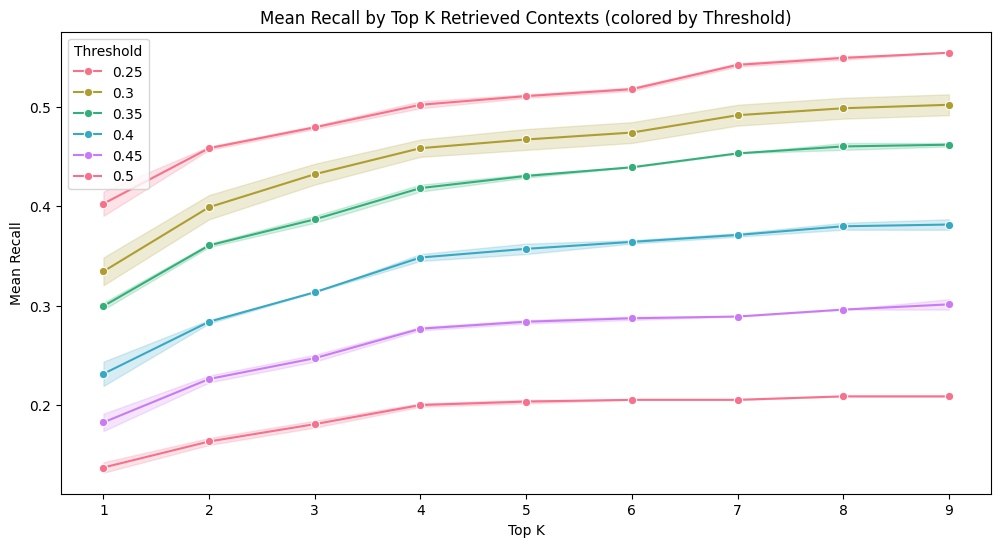

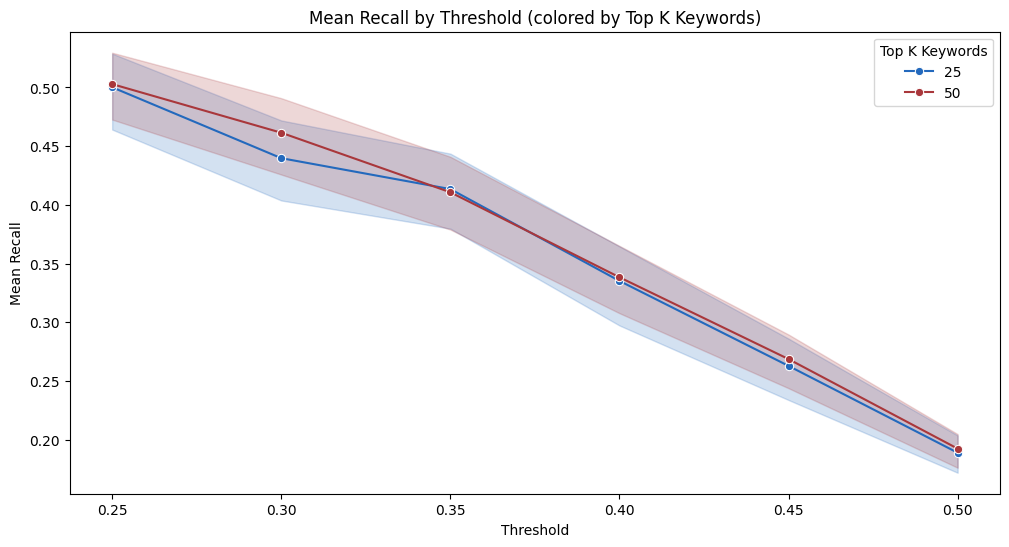

In [125]:
plot_mean_recall_kws(eval_retrieval_kws)

### Semantic Retrieval Evaluation

In [145]:
BERT_SCORE = BertScore(per_instance_score=True, device="mps")

In [146]:
def compute_recall_semantic(
    reference: str,
    retrieved_values: List[str],
    top_k: int = 1,
    top_k_kws: int = 10,
    threshold:float = 0.5,
    debug: bool = False,
) -> float:
    
    recall = 0.0

    retrieved_values = retrieved_values[:top_k]
    references = [reference] * len(retrieved_values)
    predictions = retrieved_values.copy()
    result = BERT_SCORE(references=references, predictions=predictions)
    max_score = max(result.extra["bertscore"]["recall"])
    
    return float(max_score >= threshold), max_score

def evaluate_contexts_semantic(
    response: pd.DataFrame,
    threshold=0.5,
    top_k:int = 1,
    top_k_kws: int = 10,
    debug:bool=False
) -> pd.DataFrame:
    if "question" not in response and "prediction" not in response and "reference" not in response:
        response = simplify_response(response)

    response = response[response.retrieved_contexts.str.len() != 0]

    results = []
    for row in response.itertuples():
        context = row.context
        retrieved_contexts = row.retrieved_contexts
        retrieved_contexts = list(map(lambda x: x["page_content"], retrieved_contexts))
        recall, score = compute_recall_semantic(
            context,
            retrieved_contexts,
            threshold=threshold,
            top_k=top_k,
            top_k_kws=top_k_kws,
            debug=debug
        )
        if debug:
            print(recall, score)
        results.append(dict(
            context=context,
            question=row.question,
            answer=row.reference,
            prediction=row.prediction,
            retrieved_contexts=retrieved_contexts,
            recall=recall,
            score=score,
        ))
    return pd.DataFrame(results)

In [147]:
def batch_eval_semantic_v2(response):
    thresholds = [0.5, 0.65]
    top_k_vals = [1, 5, 10]
    for threshold in thresholds:
        for top_k in top_k_vals:
            logger.debug(f"Evaluating for threshold={threshold}, top_k={top_k}")
            result = evaluate_contexts_semantic_v2(
                response,
                threshold=threshold,
                top_k=top_k, 
                top_k_kws=50,
                debug=False)
            fname = f"data/eval-context-bertscore-{threshold}-{top_k}.csv"
            logger.debug(f"Dumping eval to {fname}")
            result.to_csv(fname, index=False)

def load_context_eval_semantic() -> pd.DataFrame:
    dfs = []
    pattern = "eval-context-bertscore-([0-9.]+)-([0-9]+).csv"
    for path in glob.glob("data/evals/retrieval/bertscore/eval-context-bertscore*.csv"):
        df = pd.read_csv(path)
        match = re.search(pattern, path)
        if match:
            df["threshold"] = float(match.group(1))
            df["top_k"] = int(match.group(2))
        dfs.append(df)
    return pd.concat(dfs, axis=0)

In [157]:
def plot_mean_recall_semantic(df):
    df = df.copy()
    df['top_k'] = pd.to_numeric(df['top_k'], errors='coerce')
    df['threshold'] = pd.to_numeric(df['threshold'], errors='coerce')
    df['recall'] = pd.to_numeric(df['recall'], errors='coerce')
    # df['top_k_kws'] = pd.to_numeric(df['top_k_kws'], errors='coerce')

    df_mean_recall = df.groupby(['threshold', 'top_k'])['recall'].mean().reset_index()

    # mean recall vs. top_k with lines for each threshold
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_mean_recall, x='top_k', y='recall', hue='threshold', marker='o', palette='hls')
    plt.title('Mean Recall by Top K (colored by Threshold)')
    plt.xlabel('Top K')
    plt.ylabel('Mean Recall')
    plt.legend(title='Threshold')
    plt.show()

    # mean recall vs threshold per top_k
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_mean_recall, x='threshold', y='recall', hue='top_k', marker='o', palette='husl')
    plt.title('Mean Recall by Top K (colored by top_k)')
    plt.xlabel("Threshold")
    plt.ylabel('Mean Recall')
    plt.legend(title='top_k')
    plt.show()


In [160]:
eval_retrieval_semantic = load_context_eval_semantic()
eval_retrieval_semantic.head()

,context,question,answer,prediction,retrieved_contexts,recall,score,threshold,top_k
0,Genome-wide transcriptional profiling showed t...,Where were the gene expression alterations in ...,reducing gravity levels in the International S...,The gene expression alterations in Drosophila ...,['26-Jun-2013 notifications share GeneLab ID...,1.0,0.709230,0.5,10
1,Genome-wide transcriptional profiling showed t...,What kind of experiments showed differential r...,simulation experiments on ground testing space...,Experiments involving reducing gravity levels ...,['26-Jun-2013 notifications share GeneLab ID...,1.0,0.701952,0.5,10
2,Genome-wide transcriptional profiling showed t...,What is overrepresented in the different exper...,the same GO groups including a large multigene...,"The same GO groups, including a large multigen...","['Curiously, although <b>particular</b> <b>gen...",1.0,0.706340,0.5,10
3,Genome-wide transcriptional profiling showed t...,What are the implications of the findings in t...,The findings indicate that the finely adjusted...,The findings suggest that the transcriptome is...,"['These results suggest that, in addition to b...",1.0,0.722527,0.5,10
4,The objective of the Rodent Research-5 (RR-5) ...,What was the main goal of the Rodent Research-...,to evaluate bone loss in mice during spaceflig...,The main goal of the Rodent Research-5 (RR-5) ...,['12-Aug-2019 notifications share GeneLab ID...,1.0,0.587473,0.5,10


In [161]:
eval_retrieval_semantic.describe()

,recall,score,threshold,top_k
count,3444.000000,3444.000000,3444.000000,3444.000000
mean,0.527294,0.581817,0.575000,5.333333
std,0.499327,0.107731,0.075011,3.682322
min,0.000000,0.357976,0.500000,1.000000
25%,0.000000,0.490861,0.500000,1.000000
50%,1.000000,0.572280,0.575000,5.000000
75%,1.000000,0.675793,0.650000,10.000000
max,1.000000,0.936264,0.650000,10.000000


In [167]:
# sns.boxplot(x='top_k', y='score', data=eval_retrieval_semantic, palette="Set3")

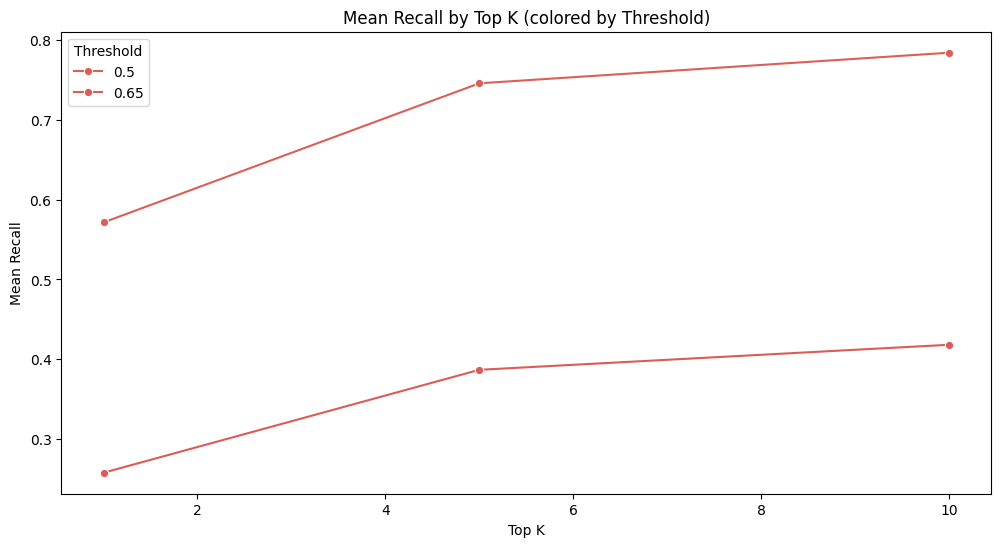

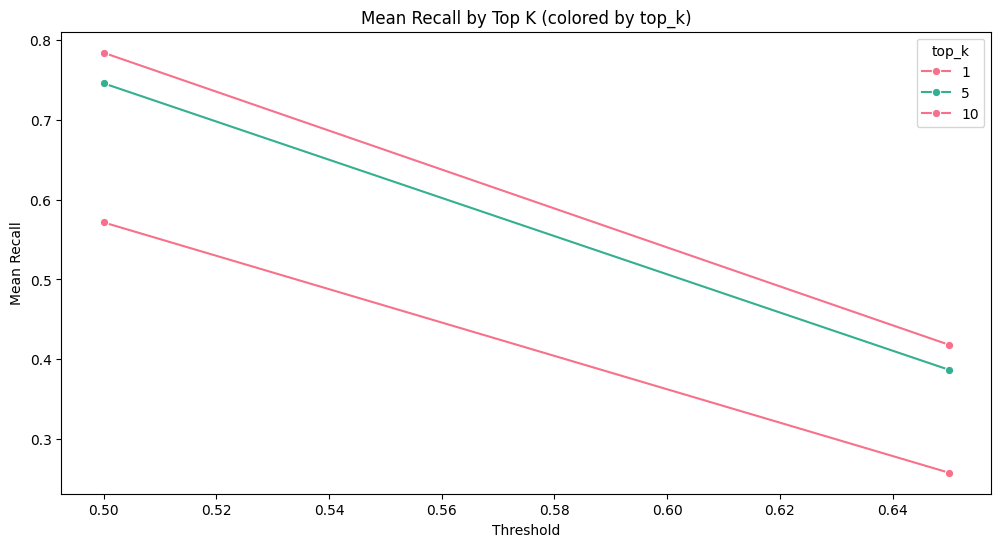

In [168]:
plot_mean_recall_semantic(eval_retrieval_semantic)

## QA Evaluation

Here we focus on semantic evaluation of generated answers.

We use following metrics:


1. Exacth Match
2. METEOR (Metric for Evaluation of Translation with Explicit Ordering)
    - more aligned with human judgment
    - accounts for exact word matches, synonyms, and paraphrases
    - useful for evaluating correctness across varied wordings
3. ROUGE (Recall-Oriented Understudy for Gisting Evaluation)
   - focuses on recall, measuring word overlaps with reference
   - indicates content overlap rather than linguistic quality
   - lower score may suggest fewer exact word matches
4. Bert Score
    - semantic similarity using contextual embeddings
    - measures how well the generated answers match with references in meaning
    - generalized comparison for a variety of downstream tasks (QA, Translation, Summarization, etc.)

In [202]:
def evaluate_qa(response: pd.DataFrame) -> pd.DataFrame:
    if "question" not in response and "prediction" not in response and "reference" not in response:
        response = simplify_response(response)
    evaluator = Evaluator(metrics=[
        BertScore(),
        ExactMatchMetric(),
        MeteorMetric(),
        RougeMetric(),
    ])
    results = evaluator(
        references=response["reference"].to_list(),
        predictions=response["prediction"].to_list()
    )
    results = pd.DataFrame(results)
    return results

In [203]:
def simplify_response(response: pd.DataFrame) -> pd.DataFrame:
    response = response.copy()
    response["result"] = response["result"].apply(ast.literal_eval)
    res = []
    for row in response.itertuples():
        res.append(dict(
            context=row.reference_context,
            context_hash=row.context_hash,
            question=row.question,
            reference=row.reference_answer,
            ground_truth=row.reference_answer,
            prediction=row.result["answer"],
            retrieved_contexts=row.result["source_documents"]
        ))
    return pd.DataFrame(res)

In [204]:
def plot_eval_result(df: pd.DataFrame):
    plt.figure(figsize=(12, 8))
    barplot = sns.barplot(x='metric_name', y='score', data=df, palette='husl')
    for p in barplot.patches:
        barplot.annotate(format(p.get_height(), '.3f'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 9), 
                         textcoords = 'offset points')
    plt.title('Comparison of Metric Scores')
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
    plt.show()

In [205]:
eval_qa = evaluate_qa(
    response=simplify_response(pd.read_csv("data/responses-gpt-3.5-turbo.csv"))
)

/Users/npantha/dev/impact/experiments/osdr-bot/venv/lib/python3.10/site-packages/jury/metrics/_core/auto.py:106: UserWarning: Metric exact_match is not available on jury, falling back to evaluate metric. You may not fully utilize this metric for different input types, e.g multiple predictions or multiple references.
  warnings.warn(


In [206]:
eval_qa

,score,total_items,metric_name,empty_items,extra
0,0.564440,295,BertScore,0,"{'bertscore': {'score': 0.5644399915711354, 'p..."
1,0.013559,295,ExactMatchMetric,0,"{'exact_match': 0.013559322033898305, 'flatten..."
2,0.383189,295,MeteorMetric,0,{'meteor': {'score': 0.38318901990050613}}
3,0.245379,295,RougeMetric,0,"{'rouge': {'rouge1': 0.2831125083117858, 'roug..."


/var/folders/_y/xn9wmmrx1_s68jvjw4gzmxfm0000gn/T/ipykernel_43387/2349567968.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='metric_name', y='score', data=df, palette='husl')


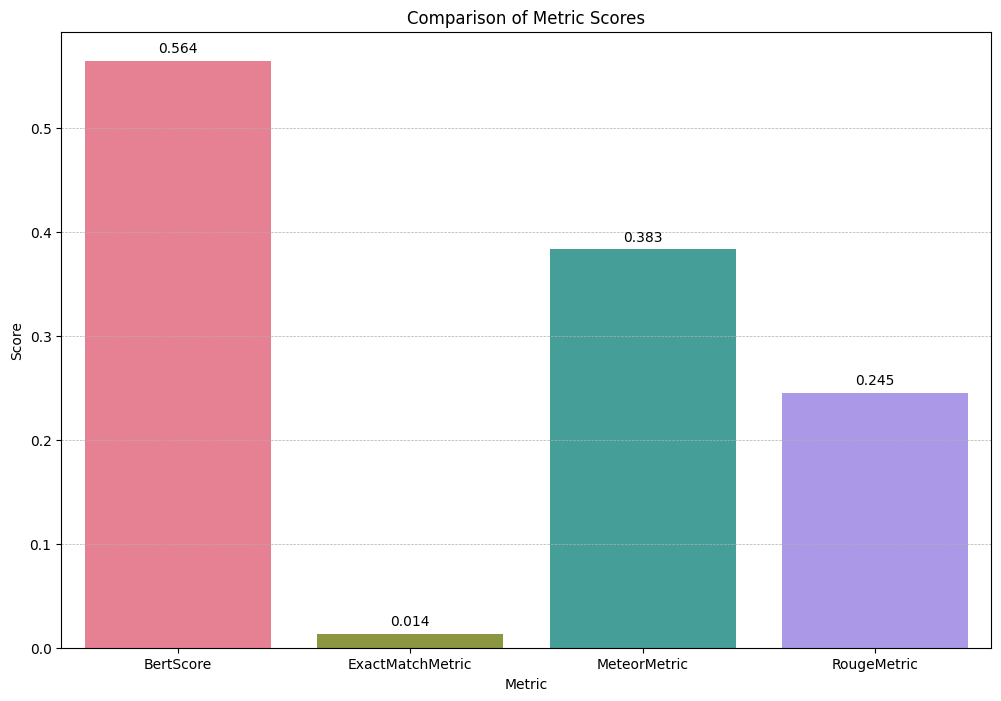

In [207]:
plot_eval_result(eval_qa)

# Footnotes
- [evalem](https://github.com/NASA-IMPACT/evalem)